In [7]:
import numba
import sys
sys.path.insert(0, './python_lib')
import networkx as nx
import numpy as np
import graph_gen
import model
import random
from collections import defaultdict
import torch
import math
import solvers

In [8]:
%matplotlib inline

In [9]:
m = n = l = 4 # L of square grid

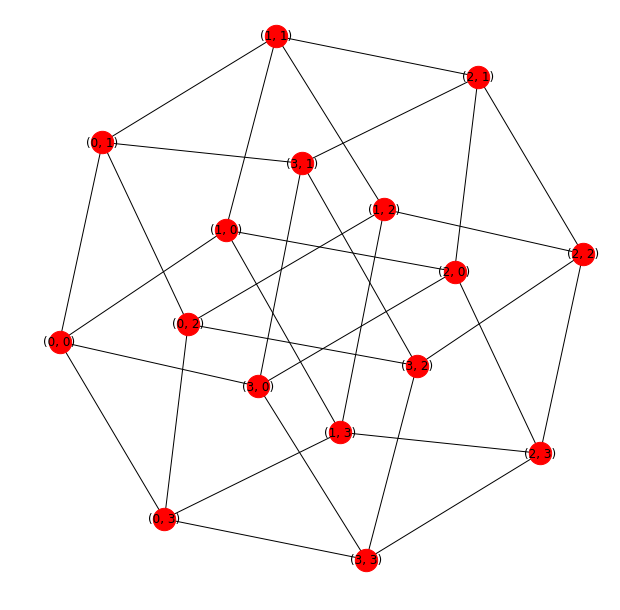

In [10]:
import imp 

import graph_gen
imp.reload(graph_gen)

periodic = True
N, J_interaction = graph_gen.grid_2d_interaction(n,m, periodic=periodic)

#H = np.random.random(N)
H=np.zeros(N)

betas_fast = np.arange(1e-6,2.1,1e-1)

j_start = 1
j = graph_gen.fixed_value(j_start)
J = graph_gen.set_J(J_interaction, j)
#J_rand = graph_gen.set_J(J_interaction_rand, j)

#N_rand, J_interaction_rand = graph_gen.tree_interaction(Degree, Height, rand=True)

In [11]:
tree = model.model(N, H, J, J_interaction)
res_ex = solvers.exact_sol(tree, betas_fast)

beta: 0.0, Fe: -693147.181 Energy: -2e-06 M: 1.74e-18 S: 0.693
beta: 0.1, Fe: -7.033 Energy: -0.206 M: 5.39e-18 S: 0.683
beta: 0.2, Fe: -3.679 Energy: -0.456 M: -8.78e-19 S: 0.644
beta: 0.3, Fe: -2.664 Energy: -0.844 M: 4.59e-17 S: 0.546
beta: 0.4, Fe: -2.275 Energy: -1.38 M: 2.76e-17 S: 0.358
beta: 0.5, Fe: -2.138 Energy: -1.76 M: 0.0 S: 0.191
beta: 0.6, Fe: -2.089 Energy: -1.91 M: 0.0 S: 0.109
beta: 0.7, Fe: -2.068 Energy: -1.96 M: 0.0 S: 0.0731
beta: 0.8, Fe: -2.056 Energy: -1.98 M: 0.0 S: 0.0573
beta: 0.9, Fe: -2.049 Energy: -1.99 M: 0.0 S: 0.05
beta: 1.0, Fe: -2.044 Energy: -2.0 M: 0.0 S: 0.0465
beta: 1.1, Fe: -2.040 Energy: -2.0 M: -5.36e-14 S: 0.0449
beta: 1.2, Fe: -2.036 Energy: -2.0 M: 0.0 S: 0.0441
beta: 1.3, Fe: -2.033 Energy: -2.0 M: 0.0 S: 0.0437
beta: 1.4, Fe: -2.031 Energy: -2.0 M: 0.0 S: 0.0435
beta: 1.5, Fe: -2.029 Energy: -2.0 M: 0.0 S: 0.0434
beta: 1.6, Fe: -2.027 Energy: -2.0 M: 0.0 S: 0.0434
beta: 1.7, Fe: -2.025 Energy: -2.0 M: 0.0 S: 0.0433
beta: 1.8, Fe: -2.024 

In [13]:
res_nn = solvers.nn_sol(tree, betas_fast, max_step=500, bias = True, 
                        z2 = False, x_hat_clip = False)
res_nn["name"]="nn"

fe: -693147.184 std_fe: 3.41E-02 M: 0.000 S: 0.693 E: 0.002
fe: -7.033 std_fe: 3.18E-02 M: -0.001 S: 0.683 E: -0.202
fe: -3.673 std_fe: 6.74E-02 M: 0.009 S: 0.648 E: -0.434
fe: -2.638 std_fe: 1.07E-01 M: 0.000 S: 0.570 E: -0.739
fe: -2.239 std_fe: 8.99E-02 M: 0.015 S: 0.327 E: -1.421
fe: -2.122 std_fe: 4.16E-02 M: -0.003 S: 0.151 E: -1.820
fe: -2.084 std_fe: 1.75E-02 M: -0.015 S: 0.088 E: -1.936
fe: -2.066 std_fe: 9.68E-03 M: 0.031 S: 0.063 E: -1.977
fe: -2.056 std_fe: 8.66E-03 M: -0.011 S: 0.053 E: -1.990
fe: -2.049 std_fe: 3.24E-03 M: 0.011 S: 0.048 E: -1.995
fe: -2.044 std_fe: 1.60E-03 M: 0.009 S: 0.046 E: -1.997
fe: -2.040 std_fe: 2.14E-03 M: -0.007 S: 0.045 E: -1.999
fe: -2.036 std_fe: 2.24E-03 M: 0.001 S: 0.044 E: -1.999
fe: -2.033 std_fe: 3.61E-03 M: 0.010 S: 0.044 E: -1.999
fe: -2.031 std_fe: 4.14E-03 M: -0.001 S: 0.044 E: -1.999
fe: -2.029 std_fe: 4.88E-03 M: 0.004 S: 0.044 E: -1.999
fe: -2.027 std_fe: 4.39E-03 M: 0.013 S: 0.044 E: -2.000
fe: -2.025 std_fe: 4.22E-03 M: 0.010 S

In [12]:
res_nn_z2 = solvers.nn_sol(tree, betas_fast, max_step=500,
                           bias = True, z2 = True, x_hat_clip = False)
res_nn_z2["name"]="nn_z2"

fe: -693148.626 std_fe: 6.34E+01 M: 0.000 S: 0.693 E: -0.001
fe: -7.033 std_fe: 2.16E-02 M: 0.001 S: 0.683 E: -0.204
fe: -3.677 std_fe: 3.63E-02 M: -0.004 S: 0.645 E: -0.453
fe: -2.661 std_fe: 4.21E-02 M: 0.007 S: 0.548 E: -0.834
fe: -2.272 std_fe: 3.32E-02 M: 0.003 S: 0.352 E: -1.394
fe: -2.137 std_fe: 1.63E-02 M: 0.006 S: 0.187 E: -1.764
fe: -2.089 std_fe: 5.98E-03 M: 0.003 S: 0.106 E: -1.913
fe: -2.068 std_fe: 2.90E-03 M: 0.004 S: 0.074 E: -1.963
fe: -2.056 std_fe: 1.02E-03 M: 0.005 S: 0.058 E: -1.984
fe: -2.049 std_fe: 5.52E-04 M: -0.013 S: 0.050 E: -1.994
fe: -2.044 std_fe: 5.19E-04 M: -0.022 S: 0.047 E: -1.997
fe: -2.040 std_fe: 2.10E-03 M: 0.005 S: 0.045 E: -1.999
fe: -2.036 std_fe: 1.32E-03 M: 0.013 S: 0.044 E: -1.999
fe: -2.033 std_fe: 1.99E-03 M: 0.008 S: 0.044 E: -2.000
fe: -2.031 std_fe: 2.64E-03 M: -0.001 S: 0.044 E: -2.000
fe: -2.029 std_fe: 3.84E-03 M: 0.006 S: 0.044 E: -1.999
fe: -2.027 std_fe: 4.51E-03 M: 0.019 S: 0.044 E: -2.000
fe: -2.025 std_fe: 4.31E-03 M: -0.007 S

In [14]:
res_bp = solvers.bp_sol(tree, betas_fast)
res_bp["name"]="bp"

fe: -693147.181, ener: -0.000, M: -0.000, iter 3
fe: -7.031, ener: -0.199, M: 0.000, iter 1
fe: -3.664, ener: -0.395, M: 0.000, iter 1
fe: -2.606, ener: -0.583, M: 0.000, iter 1
fe: -2.123, ener: -0.760, M: 0.000, iter 1
fe: -1.867, ener: -0.924, M: 0.000, iter 1
fe: -1.722, ener: -1.074, M: 0.000, iter 1
fe: -1.640, ener: -1.209, M: 0.000, iter 1
fe: -1.593, ener: -1.328, M: 0.000, iter 1
fe: -1.570, ener: -1.433, M: 0.000, iter 1
fe: -1.561, ener: -1.523, M: 0.000, iter 1
fe: -1.561, ener: -1.601, M: 0.000, iter 1
fe: -1.567, ener: -1.667, M: 0.000, iter 1
fe: -1.577, ener: -1.723, M: 0.000, iter 1
fe: -1.589, ener: -1.771, M: 0.000, iter 1
fe: -1.603, ener: -1.810, M: 0.000, iter 1
fe: -1.617, ener: -1.843, M: 0.000, iter 1
fe: -1.631, ener: -1.871, M: 0.000, iter 1
fe: -1.645, ener: -1.894, M: 0.000, iter 1
fe: -1.658, ener: -1.912, M: 0.000, iter 1
fe: -1.672, ener: -1.928, M: 0.000, iter 1


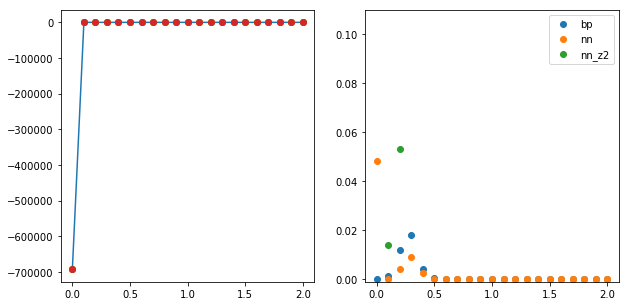

In [25]:
%matplotlib inline
label="fe"
plt= solvers.plot_quantity(label, res_ex, [res_bp, res_nn, res_nn_z2])
plt.ylim(-0.001,0.11)
plt.show()

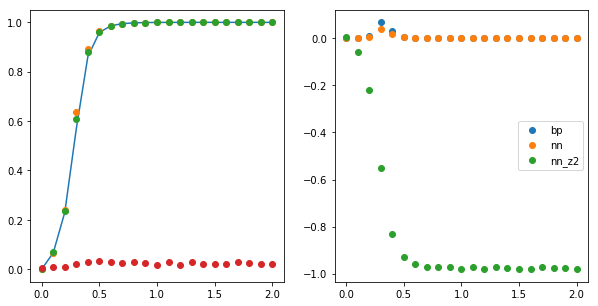

In [20]:
%matplotlib inline
label="M"
plt= solvers.plot_quantity(label, res_ex, [res_bp, res_nn, res_nn_z2])
plt.show()

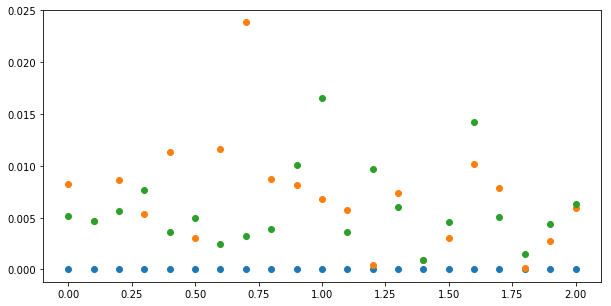

In [17]:
%matplotlib inline
label="M_i"
plt= solvers.plot_quantity_sum(label, res_ex, [res_bp, res_nn, res_nn_z2])
plt.show()

# With random field

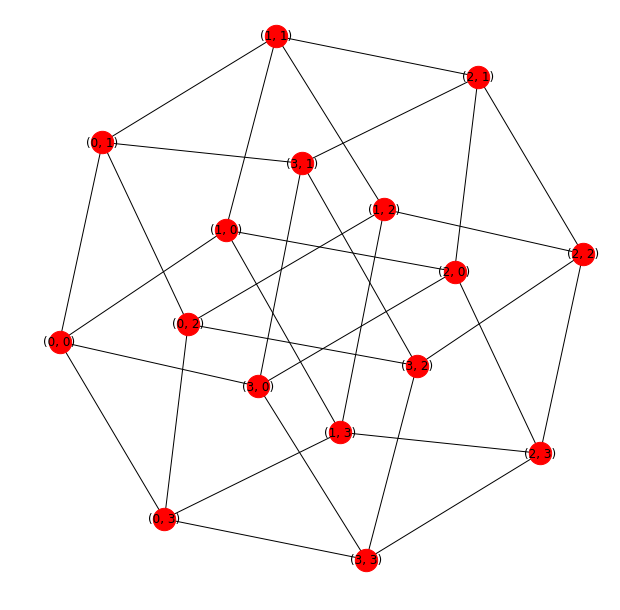

In [18]:
periodic = True
N, J_interaction = graph_gen.grid_2d_interaction(n,m, periodic=periodic)

H = np.random.random(N)
#H=np.zeros(N)

betas_fast = np.arange(1e-6,2.1,1e-1)

j = graph_gen.fixed_value(j_start)
J = graph_gen.set_J(J_interaction, j)
#J_rand = graph_gen.set_J(J_interaction_rand, j)

#N_rand, J_interaction_rand = graph_gen.tree_interaction(Degree, Height, rand=True)

In [19]:
tree = model.model(N, H, J, J_interaction)
res_ex = solvers.exact_sol(tree, betas_fast)
res_nn = solvers.nn_sol(tree, betas_fast, max_step=500, bias = True, 
                        z2 = False, x_hat_clip = False)
res_nn["name"]="nn"
res_nn_z2 = solvers.nn_sol(tree, betas_fast, max_step=500,
                           bias = True, z2 = True, x_hat_clip = False)
res_nn_z2["name"]="nn_z2"
res_bp = solvers.bp_sol(tree, betas_fast)
res_bp["name"]="bp"

beta: 0.0, Fe: -693147.181 Energy: -2.25e-06 M: 4.26e-07 S: 0.693
beta: 0.1, Fe: -7.050 Energy: -0.247 M: 0.0665 S: 0.68
beta: 0.2, Fe: -3.734 Energy: -0.626 M: 0.23 S: 0.622
beta: 0.3, Fe: -2.806 Energy: -1.33 M: 0.569 S: 0.444
beta: 0.4, Fe: -2.529 Energy: -2.0 M: 0.861 S: 0.211
beta: 0.5, Fe: -2.456 Energy: -2.28 M: 0.959 S: 0.0882
beta: 0.6, Fe: -2.436 Energy: -2.37 M: 0.986 S: 0.0383
beta: 0.7, Fe: -2.429 Energy: -2.4 M: 0.995 S: 0.0171
beta: 0.8, Fe: -2.427 Energy: -2.42 M: 0.998 S: 0.00774
beta: 0.9, Fe: -2.426 Energy: -2.42 M: 0.999 S: 0.00353
beta: 1.0, Fe: -2.426 Energy: -2.42 M: 1.0 S: 0.00161
beta: 1.1, Fe: -2.426 Energy: -2.43 M: 1.0 S: 0.000734
beta: 1.2, Fe: -2.426 Energy: -2.43 M: 1.0 S: 0.000335
beta: 1.3, Fe: -2.426 Energy: -2.43 M: 1.0 S: 0.000152
beta: 1.4, Fe: -2.426 Energy: -2.43 M: 1.0 S: 6.93e-05
beta: 1.5, Fe: -2.426 Energy: -2.43 M: 1.0 S: 3.14e-05
beta: 1.6, Fe: -2.426 Energy: -2.43 M: 1.0 S: 1.43e-05
beta: 1.7, Fe: -2.426 Energy: -2.43 M: 1.0 S: 6.45e-06
bet

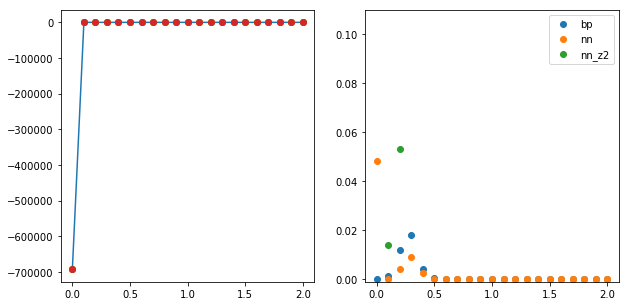

In [21]:
%matplotlib inline
label="fe"
plt= solvers.plot_quantity(label, res_ex, [res_bp, res_nn, res_nn_z2])
plt.ylim(-0.001,0.11)
plt.show()

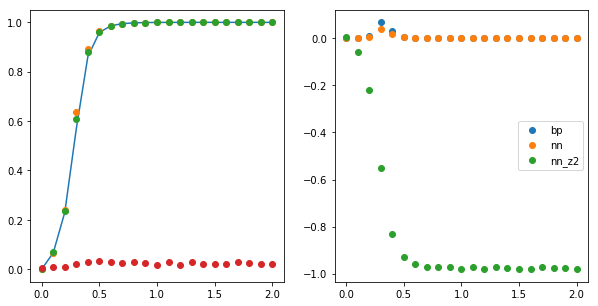

In [22]:
%matplotlib inline
label="M"
plt= solvers.plot_quantity(label, res_ex, [res_bp, res_nn, res_nn_z2])
plt.show()

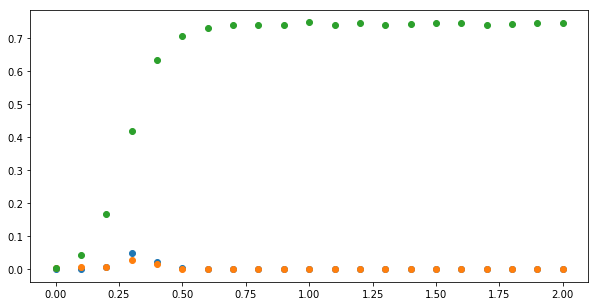

In [23]:
%matplotlib inline
label="M_i"
plt= solvers.plot_quantity_sum(label, res_ex, [res_bp, res_nn, res_nn_z2])
plt.show()